Epoch 1 Train Loss: 1.8438, Train Acc: 23.57%
Eval Acc: 16.36%
Saved best model.
Epoch 2 Train Loss: 1.6639, Train Acc: 33.62%
Eval Acc: 30.82%
Saved best model.
Epoch 3 Train Loss: 1.5704, Train Acc: 37.81%
Eval Acc: 41.71%
Saved best model.
Epoch 4 Train Loss: 1.5252, Train Acc: 38.93%
Eval Acc: 49.29%
Saved best model.
Epoch 5 Train Loss: 1.4853, Train Acc: 41.72%
Eval Acc: 52.77%
Saved best model.
Epoch 6 Train Loss: 1.4613, Train Acc: 43.24%
Eval Acc: 54.86%
Saved best model.
Epoch 7 Train Loss: 1.4374, Train Acc: 44.10%
Eval Acc: 56.98%
Saved best model.
Epoch 8 Train Loss: 1.4106, Train Acc: 44.94%
Eval Acc: 59.38%
Saved best model.
Epoch 9 Train Loss: 1.4020, Train Acc: 44.37%
Eval Acc: 60.66%
Saved best model.
Epoch 10 Train Loss: 1.3959, Train Acc: 44.90%
Eval Acc: 62.22%
Saved best model.
Epoch 11 Train Loss: 1.3935, Train Acc: 45.09%
Eval Acc: 63.53%
Saved best model.
Epoch 12 Train Loss: 1.3498, Train Acc: 46.41%
Eval Acc: 64.98%
Saved best model.
Epoch 13 Train Loss: 1.32

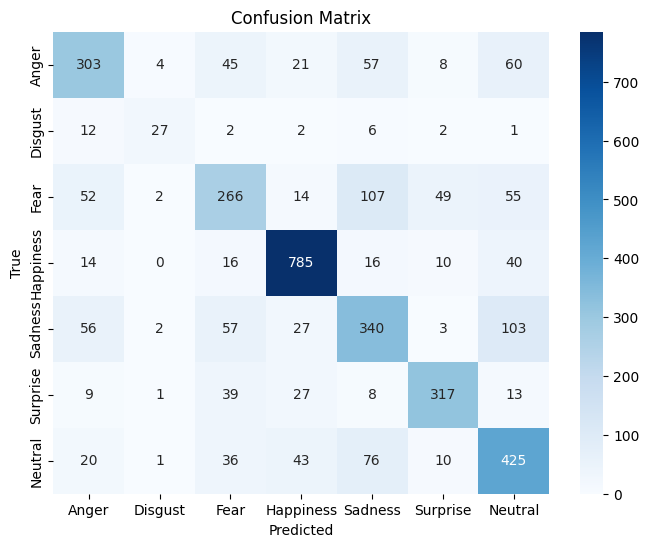

In [ ]:
# ----- Imports -----
!pip install snntorch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import models
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import random
import snntorch as snn
from snntorch import surrogate

# ===== Config =====
class CFG:
    img_size = 112
    batch_size = 64 if torch.cuda.is_available() else 32
    epochs = 25
    base_lr = 3e-4
    weight_decay = 1e-4
    label_smoothing = 0.15
    timesteps = 8
    early_conf_thresh = 0.93
    ema_decay = 0.999
    mixup_alpha = 0.3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== Dataset Class =====
class FER2013Dataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.iloc[idx]['pixels']
        pixels = np.array([int(p) for p in pixels.split()]).reshape(48, 48).astype(np.uint8)
        img = Image.fromarray(pixels).convert("RGB")  # Convert to RGB for EfficientNet
        if self.transform:
            img = self.transform(img)
        label = int(self.data.iloc[idx]['emotion'])
        return img, label

# ===== Data Transforms =====
transform_train = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])

transform_val = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])

# ===== Load Dataset =====
dataset = FER2013Dataset('fer2013.csv', transform=transform_train)
indices = list(range(len(dataset)))
train_indices, val_indices = train_test_split(indices, test_size=0.1, random_state=42)
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
val_dataset.dataset.transform = transform_val

train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=2, pin_memory=True)

# ===== Model Definition =====
backbone = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
feat_dim = backbone.classifier[1].in_features
feature_extractor = nn.Sequential(backbone.features, nn.AdaptiveAvgPool2d(1), nn.Flatten()).to(device)

class CNNDeepSNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = feature_extractor
        self.timesteps = CFG.timesteps
        self.fc1 = nn.Linear(feat_dim, 512, bias=False)
        self.bn1 = nn.BatchNorm1d(512)
        self.lif1 = snn.Leaky(beta=0.95, spike_grad=surrogate.fast_sigmoid())
        self.fc2 = nn.Linear(512, 256, bias=False)
        self.bn2 = nn.BatchNorm1d(256)
        self.lif2 = snn.Leaky(beta=0.95, spike_grad=surrogate.fast_sigmoid())
        self.dropout = nn.Dropout(0.25)
        self.fc3 = nn.Linear(256, 7)  # 7 output classes

    def forward(self, x):
        B = x.size(0)
        feats = self.backbone(x)
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        logit_sum = torch.zeros(B, self.fc3.out_features, device=feats.device)
        for _ in range(self.timesteps):
            h1 = self.fc1(feats)
            h1 = self.bn1(h1)
            spk1, mem1 = self.lif1(h1, mem1)
            h2 = self.fc2(spk1)
            h2 = self.bn2(h2)
            spk2, mem2 = self.lif2(h2, mem2)
            out = self.fc3(self.dropout(spk2))
            logit_sum += out
        return logit_sum / self.timesteps

model = CNNDeepSNN().to(device)

# ===== EMA Helper Class =====
class EMA:
    def __init__(self, model, decay=CFG.ema_decay):
        self.decay = decay
        self.shadow = {}
        for k, v in model.state_dict().items():
            if v.dtype.is_floating_point:
                self.shadow[k] = v.detach().clone()
        self.keys = list(self.shadow.keys())

    def update(self, model):
        with torch.no_grad():
            sd = model.state_dict()
            for k in self.keys:
                self.shadow[k].mul_(self.decay).add_(sd[k].detach(), alpha=1 - self.decay)

    def apply_to(self, model):
        sd = model.state_dict()
        new_sd = {}
        for k, v in sd.items():
            new_sd[k] = self.shadow[k].clone() if k in self.shadow else v.clone()
        model.load_state_dict(new_sd)

ema = EMA(model)

# ===== Loss, optimizer, scheduler =====
criterion = nn.CrossEntropyLoss(label_smoothing=CFG.label_smoothing)
optimizer = optim.AdamW(model.parameters(), lr=CFG.base_lr, weight_decay=CFG.weight_decay)
total_steps = CFG.epochs * len(train_loader)
warmup = int(0.1 * total_steps)
def lr_lambda(step):
    if step < warmup:
        return float(step) / warmup
    progress = float(step - warmup) / (total_steps - warmup)
    return 0.5 * (1 + np.cos(np.pi * progress))
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# ===== Mixup functions =====
def mixup_data(x, y, alpha=CFG.mixup_alpha):
    if alpha <= 0:
        return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam*x + (1 - lam)*x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam*criterion(pred, y_a) + (1-lam)*criterion(pred, y_b)

# ===== Training function =====
def train_one_epoch(epoch, global_step):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        use_mix = (random.random() < 0.8)
        if use_mix:
            inputs, y_a, y_b, lam = mixup_data(imgs, labels)
            logits = model(inputs)
            loss = mixup_criterion(criterion, logits, y_a, y_b, lam)
        else:
            logits = model(imgs)
            loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        ema.update(model)

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        global_step += 1

    train_loss = running_loss / total
    train_acc = correct / total * 100
    print(f"Epoch {epoch} Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    return train_loss, train_acc, global_step

# ===== Evaluation function =====
@torch.no_grad()
def evaluate(loader):
    model.eval()
    ema.apply_to(model)
    ys, ps = [], []
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        preds = logits.argmax(dim=1)
        ys.append(labels.cpu().numpy())
        ps.append(preds.cpu().numpy())
    y_true = np.concatenate(ys)
    y_pred = np.concatenate(ps)
    acc = (y_true == y_pred).mean()
    print(f"Eval Acc: {acc*100:.2f}%")
    return acc, y_true, y_pred

# ===== TRAINING LOOP =====
best_acc = 0
best_path = "best_snn_model.pth"
step = 0
for epoch in range(1, CFG.epochs + 1):
    train_one_epoch(epoch, step)
    val_acc, y_true, y_pred = evaluate(val_loader)
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), best_path)
        print("Saved best model.")

print(f"Training done. Best val accuracy: {best_acc*100:.2f}%")

# ===== Load best model and final evaluation =====
model.load_state_dict(torch.load(best_path))
test_acc, y_true, y_pred = evaluate(val_loader)  # Replace val_loader with test_loader if exists

# ===== Visualization =====
classes = ['Anger','Disgust','Fear','Happiness','Sadness','Surprise','Neutral']

print(classification_report(y_true, y_pred, target_names=classes))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


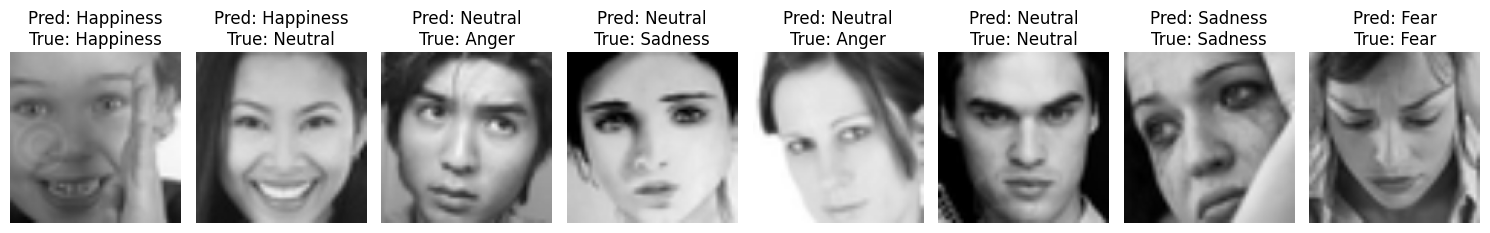

In [ ]:
def plot_samples(loader, n=8):
    model.eval()
    if len(loader.dataset) == 0:
        print("No samples to plot.")
        return
    imgs, labels = next(iter(loader))
    imgs, labels = imgs[:n].to(device), labels[:n].to(device)
    with torch.no_grad():
        logits = model(imgs)
    preds = logits.argmax(dim=1)
    imgs = imgs.cpu().permute(0, 2, 3, 1).numpy()
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    imgs = std * imgs + mean
    imgs = np.clip(imgs, 0, 1)
    plt.figure(figsize=(15, 4))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(imgs[i])
        plt.title(f"Pred: {classes[preds[i].item()]}\nTrue: {classes[labels[i].item()]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
plot_samples(val_loader)  # or test_loader if you have one
